In [1]:
import numpy as np 
import pandas as pd
import math as math
import random
import time

from keras.layers import Input, Dense
from keras.models import Model

import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import *
from shared_module import *

Using TensorFlow backend.


# Hyperparameters
- N_ANCHORS determines the number of anchors we find for each breed
- ENCODING_STRATEGY dictates the image encoding model and the size of the input vector

In [2]:
N_ANCHORS = ANCHORS_10
ENCODING_STRATEGY = VGG19_4096
ENCODING_SIZE = 4096

random.seed()

## Load the pre-processed training file. The training file already contains the anchors and cluster information.


In [3]:
INPUT_FILE_PATH = './input/labels_train_small'

training_file_path = get_path(INPUT_FILE_PATH, N_ANCHORS, ENCODING_STRATEGY)

df_train = pd.read_csv(training_file_path('anchor'))



### Statistics about the breeds in dataset

In [4]:
display(df_train.groupby(['breed']).agg(['count']))

,id,encoding,anp,cluster
,count,count,count,count
breed,,,,
basset,65,65,65,65
bluetick,68,68,68,68
collie,69,69,69,69
german_short-haired_pointer,60,60,60,60
labrador_retriever,67,67,67,67
weimaraner,68,68,68,68


### Breeds and sample of pictures

'total number of breeds 6'

collie


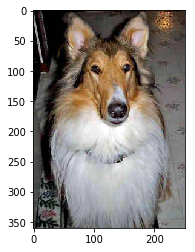

german_short-haired_pointer


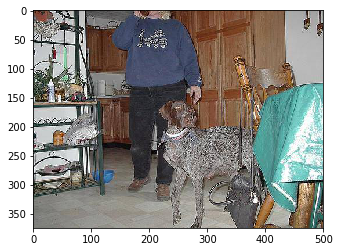

In [5]:
breeds = df_train['breed'].unique()

display('total number of breeds ' + str(len(breeds)))


def sample_by_breed(df_train):
    breeds = df_train['breed'].unique()
    random.seed()
    breed = breeds[random.randint(0, len(breeds) - 1)]
    df_breed = df_train.loc[(df_train['breed'] == breed)]
    random_index = random.randint(0, (df_breed.shape[0] - 1))
    print(breed)
    show_img(df_breed.iloc[random_index].id)

    
def show_img(image_id):
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=image_id))
    plt.imshow(img)
    plt.show()

    
sample_by_breed(df_train)
sample_by_breed(df_train)

## Load the pre-processed triplets training file
## Shuffle the triplets so that we don't just train all of a single breed first 

In [6]:
def shuffle_triplets(df_triplets):
    return df_triplets.sample(frac=1).reset_index(drop=True)

df_triplets = pd.read_csv(training_file_path('triplets'))

df_triplets = shuffle_triplets(df_triplets)
print('Total number of triplets ' + str(df_triplets.shape[0]))

Total number of triplets 19850


### Show samples of the triplets

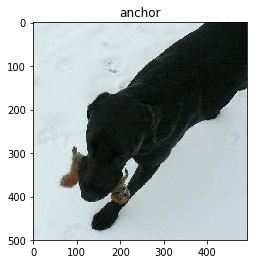

./input/train-2/42f43e8067b90430b6a05afe0b1ddbca.jpg
labrador_retriever


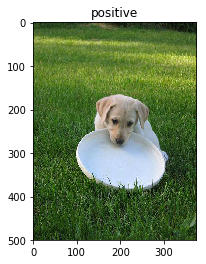

./input/train-2/75788fe1317d46dd758a9d295b83bc95.jpg
labrador_retriever


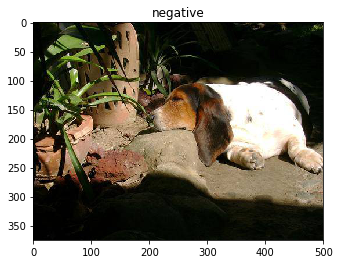

./input/train-2/290a83cd8331cfe96a1846f5e1977b55.jpg
basset


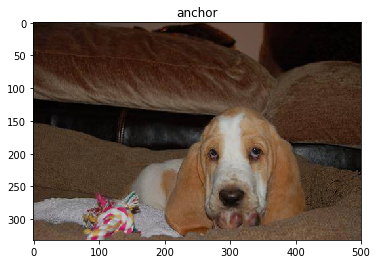

./input/train-2/07192213791150248bfb5bbe6b0b0373.jpg
basset


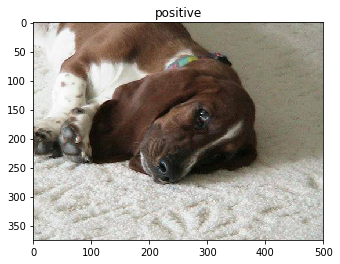

./input/train-2/3a0524c220627808889a61ad7a9da475.jpg
basset


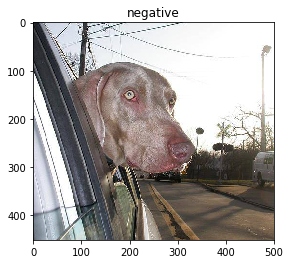

./input/train-2/9708b549ad1a33a5635220927e200fe5.jpg
weimaraner


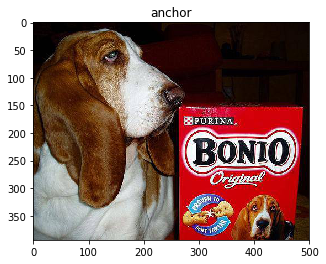

./input/train-2/819f97c27a2f46f36a88d1e1cecd8e0a.jpg
basset


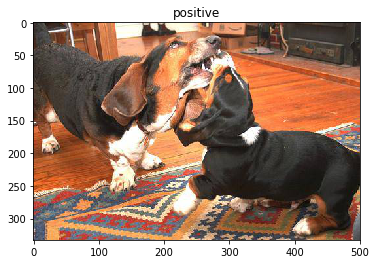

./input/train-2/0f2fbcae9ec83165d1ce5f5783fcb903.jpg
basset


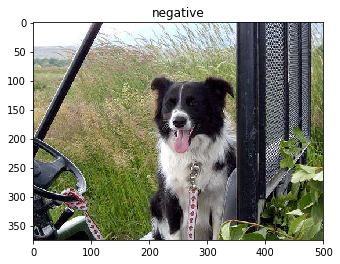

./input/train-2/152006ba4c78c907b2fc376a3336ae09.jpg
collie


In [7]:
def show_triplets(df_triplets):
    row = df_triplets.iloc[random.randint(0, df_triplets.shape[0]-1)]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['anchor_id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(row['anchor_type'])
    positive_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['positive_id'])
    img = Image.open(positive_path)
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    print(positive_path)
    print(row['positive_type'])
    negative_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['negative_id'])
    img = Image.open(negative_path)
    plt.imshow(img)
    plt.title('negative')
    plt.show()
    print(negative_path)
    print(row['negative_type'])

show_triplets(df_triplets)
show_triplets(df_triplets)
show_triplets(df_triplets)


In [8]:
encoding_model = input_encoding_model((1, ENCODING_SIZE))
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001

def load_triplets(df_triplets):
    n_triplets = df_triplets.shape[0]
    anchors = np.zeros((n_triplets, 1, ENCODING_SIZE))
    pos = np.zeros((n_triplets, 1, ENCODING_SIZE))
    negs = np.zeros((n_triplets, 1, ENCODING_SIZE))

    i = 0
    for i, triplet in df_triplets.iterrows():
        anchors[i] = np.loadtxt(triplet['anchor_encoding'])
        pos[i] = np.loadtxt(triplet['positive_encoding'])
        negs[i] = np.loadtxt(triplet['negative_encoding'])
        i = i + 1
        if (i % 1000 == 0):
            print('Loaded ' + str(i) + ' triplets')
    print('Loaded ' + str(n_triplets))
    
    return anchors, pos, negs



### Load the encoding for the given triplets into memory
### Train the model with the whole training set

because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies


In [9]:
anchors, pos, negs = load_triplets(df_triplets)
n_triplets = df_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))


training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=100, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))


df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
df_train_results_mismatch.head()

Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 6000 triplets
Loaded 7000 triplets
Loaded 8000 triplets
Loaded 9000 triplets
Loaded 10000 triplets
Loaded 11000 triplets
Loaded 12000 triplets
Loaded 13000 triplets
Loaded 14000 triplets
Loaded 15000 triplets
Loaded 16000 triplets
Loaded 17000 triplets
Loaded 18000 triplets
Loaded 19000 triplets
Loaded 19850
Epoch 1/20
19850/19850 [==============================] - 33s 2ms/step - loss: 1.1579 - inputEncodingModel_loss_1: 0.7089 - inputEncodingModel_loss_2: 0.2858 - inputEncodingModel_loss_3: 0.1631 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
Epoch 2/20
19850/19850 [==============================] - 36s 2ms/step - loss: 0.7918 - inputEncodingModel_loss_1: 0.3120 - inputEncodingModel_loss_2: 0.2763 - inputEncodingModel_loss_3: 0.2035 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000

,id,breed,encoding,anp,cluster,prediction_breed,prediction,prediction_id,prediction_encoding
1,0512c1a59449a9c8c83c95722028ac90,basset,./input/vgg19_4096/0512c1a59449a9c8c83c9572202...,P,1,bluetick,False,8700e299601a8aea94ad3e5e6094d2f0,./input/vgg19_4096/8700e299601a8aea94ad3e5e609...
29,4f031cd233512f9c4c3bbfe354510eac,basset,./input/vgg19_4096/4f031cd233512f9c4c3bbfe3545...,P,8,labrador_retriever,False,42f43e8067b90430b6a05afe0b1ddbca,./input/vgg19_4096/42f43e8067b90430b6a05afe0b1...
44,8b6e36d51e75cf0b1b81a94f33d5f5c3,basset,./input/vgg19_4096/8b6e36d51e75cf0b1b81a94f33d...,P,2,bluetick,False,09aec2a169942b17d88b4b5f1bba5886,./input/vgg19_4096/09aec2a169942b17d88b4b5f1bb...
69,05a747c5853defa2420b976a9c0918a2,bluetick,./input/vgg19_4096/05a747c5853defa2420b976a9c0...,P,9,german_short-haired_pointer,False,d222748a1eea1d4fd0dc0c7e95c7a312,./input/vgg19_4096/d222748a1eea1d4fd0dc0c7e95c...
73,1015e4eba660def32e7e52b89fe3a9c6,bluetick,./input/vgg19_4096/1015e4eba660def32e7e52b89fe...,P,7,labrador_retriever,False,42f43e8067b90430b6a05afe0b1ddbca,./input/vgg19_4096/42f43e8067b90430b6a05afe0b1...


In [10]:
def triplet_tuple(id_value, breed_value, encoding_value):
    return [id_value, breed_value, encoding_value]

def create_triplet(anchor_tuple, positive_tuple, negative_tuple):
    result = []
    for value in anchor_tuple:
        result.append(value)
    for value in positive_tuple:
        result.append(value)
    for value in negative_tuple:
        result.append(value)
    return result

def extract_triplets(df_mismatch, df_train):
    new_triplets_list = []

    for i, bad_pred in df_mismatch.iterrows():
        pred_anchors = df_train.loc[(df_train.breed == bad_pred.breed)]
        for i, pred_anchor in pred_anchors.iterrows():
            anchor = triplet_tuple(pred_anchor['id'], pred_anchor['breed'], pred_anchor['encoding'])
            positive = triplet_tuple(bad_pred['id'], bad_pred['breed'], bad_pred['encoding'])
            negative = triplet_tuple(bad_pred['prediction_id'], bad_pred['prediction_breed'], bad_pred['prediction_encoding'])
            new_triplets_list.append(create_triplet(anchor, positive, negative))
#             new_triplets_list.append(create_triplet(positive, anchor, negative))

    df_new_triplets = pd.DataFrame(new_triplets_list, columns=['anchor_id', 'anchor_type', 'anchor_encoding', 'positive_id', 'positive_type', 'positive_encoding', 'negative_id', 'negative_type', 'negative_encoding'])
    return df_new_triplets

### Load the bad prediction and train the model to recognize these against the corresponding anchors

In [11]:
df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
print(df_new_triplets.shape)
df_new_triplets.head()

anchors, pos, negs = load_triplets(df_new_triplets)
n_triplets = df_new_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=50, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))

df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]


(3213, 9)
Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 3213
Epoch 1/50
3213/3213 [==============================] - 4s 1ms/step - loss: 0.5202 - inputEncodingModel_loss_1: 0.1238 - inputEncodingModel_loss_2: 0.3343 - inputEncodingModel_loss_3: 0.0622 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
Epoch 2/50
3213/3213 [==============================] - 4s 1ms/step - loss: 0.2545 - inputEncodingModel_loss_1: 0.2003 - inputEncodingModel_loss_2: 0.0338 - inputEncodingModel_loss_3: 0.0205 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
Epoch 3/50
3213/3213 [==============================] - 4s 1ms/step - loss: 0.4032 - inputEncodingModel_loss_1: 0.1325 - inputEncodingModel_loss_2: 0.2453 - inputEncodingModel_loss_3: 0.0254 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.

3213/3213 [==============================] - 4s 1ms/step - loss: 1.0984 - inputEncodingModel_loss_1: 0.3702 - inputEncodingModel_loss_2: 0.3724 - inputEncodingModel_loss_3: 0.3558 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
Epoch 28/50
3213/3213 [==============================] - 4s 1ms/step - loss: 0.6714 - inputEncodingModel_loss_1: 0.5956 - inputEncodingModel_loss_2: 0.0368 - inputEncodingModel_loss_3: 0.0390 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
Epoch 29/50
3213/3213 [==============================] - 4s 1ms/step - loss: 0.7439 - inputEncodingModel_loss_1: 0.2899 - inputEncodingModel_loss_2: 0.1724 - inputEncodingModel_loss_3: 0.2816 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00
Epoch 30/50
3213/3213 [==============================] - 4s 1ms/step - loss: 0.7303 -